In [90]:
%reset -f

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import LinearNDInterpolator as lNDI
from scipy.interpolate import interp1d
import time
import h5py
import five_sigma_depth_func_of_time
import pickle
import time
import sata_funcs as st
import os

In [92]:
labs=['t','flux','flux_err']
# uabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
# gabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
rabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
iabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
zabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
yabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
tables=[rabnd_data,iabnd_data,zabnd_data,yabnd_data]
def dump_to_h5(data,labs):
    [sysn,lc_data]=data
    #tu,Fu,Fuerr,tg,Fg,Fgerr,tr,Fr,Frerr,ti,Fi,Fierr,tz,Fz,Fzerr,ty,Fy,Fyerr=lc_data

    grp = h5f.create_group('SystemNo_' + str(sysn))
    for iband,band in enumerate(filters): 
        table=tables[iband]
        t,f,ferr=lc_data[3*iband], lc_data[3*iband+1], lc_data[3*iband+2]
        tepm_arr = np.empty(dtype=table,shape=(t.shape[0],))
        tepm_arr[labs[0]] = t
        tepm_arr[labs[1]] = f
        tepm_arr[labs[2]] = ferr
        band_lab=band+'_data'
        grp.create_dataset(band_lab,data=tepm_arr)
        
        
        
        
def get_mu(kappa,gamma):
    return 1.0/((1.-kappa)**2-gamma**2)

m_ref=0;F_ref=1.0e12
def get_flux(m):
    return F_ref*10**(0.4*(m_ref-m))

def get_mag(F):
    return m_ref-2.5*np.log10(F/F_ref)

def get_flu_err(m,sig_m):
    delF_delm=-0.4*np.log(10.)*F_ref*10**(0.4*(m_ref-m))
    sigF=np.abs(delF_delm)*sig_m
    
    return sigF

def get_flu_err2(m,sig_m):
    del_F=get_mag(m+sig_m)-get_mag(m-sig_m)
    
    return np.abs(del_F)/2.0

def calculate_length(obj):
    try:
        return len(obj)
    except TypeError:
        return 1
def get_interp(x,y):
    method='cubic'
    return interp1d(x,y, kind=method,bounds_error=False,fill_value=(y[0],y[-1]))

def get_shifted(y_interp,x,dx=0.0,mux=1.0):
    return mux*y_interp(x-dx)

def convert_np_arr(datalist):
    ii=0
    ret=[]
    for data in datalist:
        ret.append(np.array(data))
    return ret
        
        
#convert_np_arr(f_load_microlensed_lightcurve(pickel_file1,band,micro_config1))  

In [93]:
#stored ascii files
mother_out_dir='./ML_downsampled_data/'
all_good_downsampled_data=np.loadtxt(mother_out_dir+'All_good_downsample.txt')
print(all_good_downsampled_data.shape)
idx2=np.where(all_good_downsampled_data[:,1]==2)[0]
idx4=np.where(all_good_downsampled_data[:,1]==4)[0]
print(len(idx2/2),len(idx4/4))

only_sysn_ni_data=np.loadtxt(mother_out_dir+'all_good_sys.txt')
print(len(only_sysn_ni_data[:,0]))
sysn_list_double=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==2.]
sysn_list_quad=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==4.]
print(len(sysn_list_double),len(sysn_list_quad))

(250, 16)
98 152
87
49 38


[22.21090168 21.59288992 22.18011027 22.43300077 22.4870268  22.54563153
 21.90708248 22.34520155 22.2409278  21.95352301 22.15747719 22.33597897
 22.36331487 22.42772988 21.92076452 22.55651373 21.56054904 22.15570225
 21.5897787  22.16555062 22.4297363  22.29522393 21.65849879 22.30296937
 22.43671613 21.90353322 22.5085488  22.0939451  22.17322109 21.72114362
 20.85648601 22.16780512 22.39731365 22.24711555 21.29938903 22.10137148
 22.18058313 22.05609586 22.38918219 20.39928804 21.3429931  22.52624197
 21.57740587 22.40819769 22.46032127 22.26881157 22.04233904 21.30533922
 22.32787071 22.29509393 21.78941191 20.85645365 21.65627744 21.41352109
 22.40897964 20.44929531 21.78721213 21.37358113 21.67491956 21.46831638
 21.21124241 21.01120953 21.79451887 21.98383742 22.16321191 21.73472696
 22.09780561 22.27418336 22.44278874 21.22234337 21.32697971 22.55798068
 20.35821311 20.97132604 20.47418411 20.75149427 22.09366797 22.48713293
 22.29132935 22.53154604 19.3718869  22.35501392 21

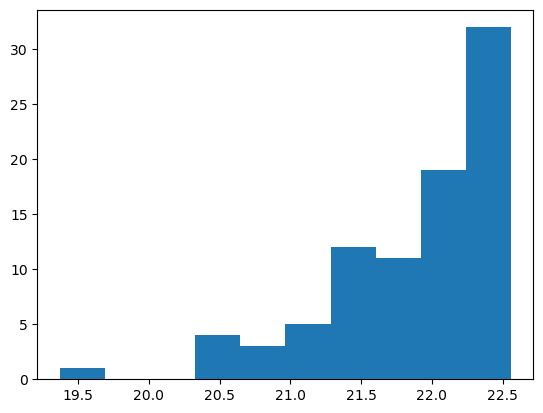

In [94]:
def get_indi(data_mat,sysn):
    return np.where(data_mat[:,0]==sysn)[0]
def construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,modelname,s_val):
    return 'SN_%s_k%.6f_g%.6f_s%.3f_redshift_source%.3f_lens%.3f_Nsim_100'%(modelname,kappa_i,gamma_i,s_val,s_z_i,lens_z_i)
def get_total_flux_mag(sysnlist):
    total_flux=[]
    total_mag=[]
    for sysn in sysnlist:
        ids=get_indi(all_good_downsampled_data,sysn)
        mu_image, source_mag=all_good_downsampled_data[ids,7:9].T
        tot_flux=np.sum(np.abs(mu_image)*st.get_flux(source_mag))
        tot_mag=st.get_mag(tot_flux)
        total_flux.append(tot_flux);total_mag.append(tot_mag)
    return np.array(total_flux), np.array(total_mag)
total_flux,total_mag=get_total_flux_mag(only_sysn_ni_data[:,0])
print(total_mag)
plt.hist(total_mag)


t11=time.time()
Nsys=10000
random_doubles=np.random.choice(sysn_list_double,Nsys).astype(int)

all_models=np.array(['me', 'n1', 'su', 'ww'])
s_values=[0.4,0.6,0.8]
bands=['u','g','r','i','y','z',"J","H"]

for iii in range(Nsys):
    ids=get_indi(all_good_downsampled_data,random_doubles[iii])
    if len(ids):
        for ii in ids:
            kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
            s_val=all_good_downsampled_data[ii,-1]
            for imod,model_i in enumerate(all_models):
                fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
                image_path=mother_out_dir+'sysn_%d/'%(random_doubles[iii])+fname
                if not os.path.exists(image_path):
                    print("Problem!!")

In [95]:
def f_observational_uncertainty(magnitude,five_sigma_depth,filter_,sigma_sys=0.005):
    mag_diff = magnitude-five_sigma_depth
    #mag_diff[mag_diff >= 3] = np.nan #sets everything which is to faint to nan
    x=10**(0.4 * mag_diff)
    gamma = {"u": 0.037, "g": 0.038, "r": 0.039, "i": 0.039, "z": 0.040, "y":0.040, "J":0.040, "H":0.040, "K":0.040}
    sigma_rand_squared = (0.04 - gamma[filter_]) * x + gamma[filter_] * x**2
    sigma_total = np.sqrt(sigma_sys**2 + sigma_rand_squared) #unit magnitude
    #print(magnitude, sigma_total)
    return sigma_total


def get_five_sigma_depth(time,filter_,moon_phase_yes_no=False):
    # get the five sigma depth
    depth_filter_ = 24.7
    

    if moon_phase_yes_no:
        # start_in_moon_phase, 0 assumes first quarter, 29.5/4 assumes  full moon, 29.5/2 assumes third quarter, 29.5*3/4 assumes new moon, 29.5 is then again firt quarter    
        start_in_moon_phase = 29.5/4
        fsd = five_sigma_depth_func_of_time.five_sigma_depth(filter_=filter_)
        
        five_sigma_depth = fsd.f_five_sigma_depth_as_function_of_time_ESO(time_to_get_five_sigma_depth = time,
                                                                          reference_depth=depth_filter_,
                                                                          start_in_moon_phase=start_in_moon_phase)
    else:
        five_sigma_depth = np.full(time.shape,depth_filter_)
        
    return five_sigma_depth

def get_artificial_mag_obs(mag,mag_sig,five_sigma_depth):
    mag_obs=np.random.normal(mag,mag_sig)
    #return mag_obs
    ids=np.where((mag_obs<five_sigma_depth) &(mag-five_sigma_depth>0.0))[0]
    if len(ids):
        mag_obs[ids]=np.random.uniform(five_sigma_depth[ids],mag[ids])
    return mag_obs
    

In [96]:
icheck=11
sysn_check=sysn_list_quad[icheck]
isysn=np.where(only_sysn_ni_data[:,0]==sysn_check)[0][0]
target_mag=total_mag[isysn]
print('sysn=',sysn_check,'target mag=',target_mag)


def get_Cs(peak_mags,mus,target_mag):
    NI=len(peak_mags)
    if NI!=len(mus)+1:
        raise ValueError("Problem, lengths of peak mag and mus are not matching")
    Cs=np.zeros(NI)
    peak_fluxes=st.get_flux(peak_mags)
    #print('target_flux=',st.get_flux(target_mag))
    Cs[0]=st.get_flux(target_mag)/(peak_fluxes[0]*(1.0+np.sum(mus)))
    for ii in range(1,NI):
        Cs[ii]=mus[ii-1]*Cs[0]*peak_fluxes[0]/peak_fluxes[ii]
    return Cs
    


ids=get_indi(all_good_downsampled_data,sysn_check)
band="i"
NI=len(ids)
if NI:
    for imod,model_i in enumerate(all_models):
        mus1=10*np.random.rand(NI-1)
        peak_mags=np.zeros(len(ids))
        for ni,ii in enumerate(ids):
            kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
            s_val=all_good_downsampled_data[ii,-1]

            fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
            image_path=mother_out_dir+'sysn_%d/'%(sysn_check)+fname
            if not os.path.exists(image_path):
                print("Problem!!")
            else:
                macro_key='macro_light_curve_%s'%(band)
                macro_mag=np.loadtxt(image_path+'/'+macro_key)
                imicro=np.random.randint(100);micro_key='micro_light_curve_%s%s'%(imicro,band)
                micro_mag=np.loadtxt(image_path+'/'+micro_key)
                peak_mags[ni]=np.min(micro_mag)
        Cs=get_Cs(peak_mags,mus1,target_mag)
        image_fluxes=Cs*st.get_flux(peak_mags)
        summed_up_mag=st.get_mag(np.sum(image_fluxes))
        print(summed_up_mag,mus1,image_fluxes/image_fluxes[0])

sysn= 17742.0 target mag= 21.211242408065157
21.211242408065157 [3.04063476 3.56989368 9.02111282] [1.         3.04063476 3.56989368 9.02111282]
21.211242408065157 [9.80543187 0.17170941 1.8833873 ] [1.         9.80543187 0.17170941 1.8833873 ]
21.211242408065157 [8.93729147 7.77153506 1.1829645 ] [1.         8.93729147 7.77153506 1.1829645 ]
21.211242408065157 [7.44684001 9.00354337 0.73193324] [1.         7.44684001 9.00354337 0.73193324]


In [97]:
def get_Om10_system(NI):
    if NI==1:
        sysn=np.random.choice(only_sysn_ni_data[:,0]) 
    elif NI==2:
        sysn=np.random.choice(sysn_list_double)
    elif NI==4:
        sysn=np.random.choice(sysn_list_quad)
    else:
        print("NI=",NI)
        raise ValueError("Problem NI should be 1 or 2 or 4")
    return sysn

In [98]:
def get_intersection(list1):
    list_union = list(set().union(*list1))
    list_intersection =list(set.intersection(*map(set, list1)))
    return sorted(list_union), sorted(list_intersection)
# list1 = [[1,2,3], [1,2,4]]
# get_intersection(list1) 
def arrange_sys_obs_mjd(Good_sys_band,Good_sys_obs_mjd_band,bands_used,Good_sys_obs_fiveSigmaDepth_band):
    Good_sys_obs_mjd_in_all_bands=[[] for _ in bands_used]
    Good_sys_obs_fiveSigmaDepth_in_all_bands=[[] for _ in bands_used]
    for iband,band in enumerate(bands_used):
        idx=np.where(np.isin(Good_sys_band[iband],good_sn_in_all_bands))[0]
        #print(min_max(good_sn_in_all_bands-np.array(Good_sys_band[iband])[idx]))
        Good_sys_obs_mjd_in_all_bands[iband]= [(Good_sys_obs_mjd_band[iband])[idxx] for idxx in idx]
        Good_sys_obs_fiveSigmaDepth_in_all_bands[iband]=[(Good_sys_obs_fiveSigmaDepth_band[iband])[idxx] for idxx in idx]
    return Good_sys_obs_mjd_in_all_bands,Good_sys_obs_fiveSigmaDepth_in_all_bands


Nsss=711*10000 # total number of dummy SN simulated to get their cadence
bands_used=['r','i','z','y']
file_name = "Good_cadence_systems_fiveSigmaDepth_riyz.pkl"
with open(file_name, 'rb') as file:
    loaded_data = pickle.load(file)

Good_sys_band=loaded_data['Good_sys_band']
Good_sys_obs_mjd_band=loaded_data['Good_sys_obs_mjd_band']
Good_sys_obs_fiveSigmaDepth_band=loaded_data['Good_sys_obs_fiveSigmaDepth_band']

all_good_sn, good_sn_in_all_bands=get_intersection(Good_sys_band)
print('#of all good sys (union)=',len(all_good_sn),'# of good sys observed in all the bands=',len(good_sn_in_all_bands))
print('in percentage: ',100*len(all_good_sn)/Nsss,100*len(good_sn_in_all_bands)/Nsss)

Good_sys_obs_mjd_in_all_bands,Good_sys_obs_fiveSigmaDepth_in_all_bands=arrange_sys_obs_mjd(Good_sys_band,Good_sys_obs_mjd_band,bands_used,Good_sys_obs_fiveSigmaDepth_band)
print(len(Good_sys_obs_mjd_in_all_bands[0]))
Ngood_cadence=len(good_sn_in_all_bands);print(Ngood_cadence)

#of all good sys (union)= 1334273 # of good sys observed in all the bands= 442608
in percentage:  18.766146272855135 6.225147679324895
442608
442608


In [99]:
cadence_id=np.random.choice(Ngood_cadence)
t_arrs=[(Good_sys_obs_mjd_in_all_bands[ii])[cadence_id] for ii in range(4)]
print(t_arrs)

[array([  3.16757157,   7.32346109,   9.13178364,   9.29007582,
        12.16574205,  12.16664146,  15.19254635,  15.31160555,
        35.12416211,  37.10488906,  39.09998625,  40.24504037,
        42.08235615,  48.05491873,  50.04264878,  67.20543935,
        71.00738038,  72.0106211 ,  79.15106945,  92.07434962,
        94.14067299,  95.12658496, 100.12333359, 105.1179024 ,
       108.06150623, 108.06197301, 113.07242674, 124.00841358,
       134.03049197, 138.00925666, 157.99190367]), array([  3.19167392,   5.30649925,  20.29550865,  20.29595939,
        31.2734677 ,  31.27705775,  35.14861376,  38.27934022,
        42.1057158 ,  42.27454394,  43.225778  ,  48.07927361,
        50.06491884,  52.9928018 ,  53.27226864,  74.17592805,
        83.18070466,  89.13405772,  92.09890573,  93.11596546,
       101.08203998, 103.10691946, 106.08055924, 106.08100798,
       113.04854628, 113.0516963 , 134.05426889]), array([  2.33333819,  20.30690521,  20.30735572,  27.2492909 ,
        31.2847

In [100]:
def f_load_microlensed_lightcurves(sysn,band,micro_configs,sn_model,NI,unlensed_im_choice=0):
    ids=get_indi(all_good_downsampled_data,sysn); NI1=len(ids)
    if NI==1:
        #print("satadru: entered here unlensed", unlensed_im_choice,band)
        #ids=np.array([ids[np.random.choice(NI1)]])
        ii=ids[unlensed_im_choice]
        macro_mags=[]
        mjds=[]
        kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
        s_val=all_good_downsampled_data[ii,-1]

        fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
        image_path=mother_out_dir+'sysn_%d/'%(sysn)+fname
        
        time_key='time_bin_center'
        time_filter=np.loadtxt(image_path+'/'+time_key)
        mjds.append(time_filter)
        macro_key='macro_light_curve_%s'%(band)
        macro_mag=np.loadtxt(image_path+'/'+macro_key)
        macro_mags.append(macro_mag)
        return mjds, macro_mags
        
    #macro_mags=[]
    micro_mags=[]
    mjds=[]
    for ni in range(NI):
        ii=ids[ni]
        kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
        s_val=all_good_downsampled_data[ii,-1]

        fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
        image_path=mother_out_dir+'sysn_%d/'%(sysn)+fname
        
        time_key='time_bin_center'
        time_filter=np.loadtxt(image_path+'/'+time_key)
        mjds.append(time_filter)

#         macro_key='macro_light_curve_%s'%(band)
#         macro_mag=np.loadtxt(image_path+'/'+macro_key)
        #imicro=np.random.randint(100);
        micro_key='micro_light_curve_%s%s'%(micro_configs[ni],band)
        micro_mag=np.loadtxt(image_path+'/'+micro_key)
        micro_mags.append(micro_mag)
        

    return mjds, micro_mags
        
#f_load_microlensed_lightcurves(798,'i',[12,77],'ww')    

In [101]:
clrs=['r','orange','brown','magenta']

def build_unresolved(params):
    t_arrs,fivesigDepth_arrs,system_number,NI,micro_configs,filters,supernova_model,dts,mus=params
    #filter_data=get_lcs(system_number,NI,micro_configs,filters,supernova_model)
    #filter_data=aa
    
    #print("mus test",mus,dts,"NI=",NI)
    
    isysn=np.where(only_sysn_ni_data[:,0]==system_number)[0][0]
    target_mag=total_mag[isysn]
    available_NI=only_sysn_ni_data[:,1][isysn].astype(int)
    
    Flist=[]#np.zeros(Nfilters,dtype=object)
    Flist_true=[]
    Mag_list=[]
    Mag_true=[]
    
    mjd_list_band_ni=[[] for i in range(Nfilters)]
    micro_mag_list_band_ni=[[] for i in range(Nfilters)]
    
    random_ni_for_unlensed=np.random.choice(available_NI)
    
    #NoiseP.extend(noise_level)
    for ifilter,filter_ in enumerate(filters):
        
        
        mjds, micro_mags=f_load_microlensed_lightcurves(system_number,filter_,micro_configs,supernova_model,NI,random_ni_for_unlensed)
        mjd_list_band_ni[ifilter].extend(mjds)
        micro_mag_list_band_ni[ifilter].extend(micro_mags)
        
        if len(mjds)!=NI and NI!=1:
            raise ValueError("Problem: NI does not match !!!")
            sys.exit()
            
        if filter_=='i':
            peak_mags=np.array([np.min(micro_mag) for micro_mag in micro_mags])
            iband_Cs=get_Cs(peak_mags,mus[1:NI],target_mag)
            
        
    #return  mjd_list_band_ni,micro_mag_list_band_ni
    for ifilter,filter_ in enumerate(filters):
        mjds=mjd_list_band_ni[ifilter]
        micro_mags=micro_mag_list_band_ni[ifilter]
        t_filter=t_arrs[ifilter]
        five_sigma_depth_filter=fivesigDepth_arrs[ifilter]
        t_maxes[ifilter].extend([t_filter.max()]);
        
        flux_filter=np.zeros(len(t_filter))
        for ni in range(NI):
            flux_micro=get_flux(micro_mags[ni])
            flux_interp=get_interp(mjds[ni],flux_micro)
            flux_image=iband_Cs[ni]*flux_interp(t_filter-dts[ni])
#             plt.plot(t_filter,flux_image,alpha=0.4,label=r"band=%s::image=%d"%(filter_,ni+1))
            flux_filter+=flux_image
        
#         plt.plot(t_filter,flux_filter,lw=2.0,c="k",ls="--")
#         plt.legend()
#         plt.show()
            
        
        Mag=get_mag(flux_filter)
        five_sigma_depth=get_five_sigma_depth(t_filter,filter_,moon_phase_yes_no=True)
        sigma_total = f_observational_uncertainty(Mag,five_sigma_depth=five_sigma_depth,filter_=filter_,sigma_sys=0.005)
        sigma_total=np.clip(sigma_total,0,1.0)
        Mag_obs=np.random.normal(Mag,sigma_total)
        #Mag_obs=get_artificial_mag_obs(Mag,sigma_total,five_sigma_depth)
        
        
        Fobs=get_flux(Mag_obs)
        Ferr=get_flu_err(Mag_obs,sigma_total)


        


        sigma_total_2 = f_observational_uncertainty(Mag,five_sigma_depth=five_sigma_depth_filter,filter_=filter_,sigma_sys=0.005)
        #sigma_total_2=np.clip(sigma_total_2,0,2.0)
        #Mag_obs_2=np.random.normal(Mag,sigma_total_2)
        Mag_obs_2=get_artificial_mag_obs(Mag,sigma_total_2,five_sigma_depth_filter)
        Fobs_2=get_flux(Mag_obs_2)
        Ferr_2=get_flu_err(Mag_obs_2,sigma_total_2)
        
#         Fsig3=get_flux(five_sigma_depth_filter)/5
#         Fobs_3=np.random.normal(flux_filter,Fsig3)
        
#         plt.errorbar(t_filter,Mag_obs,yerr=sigma_total,fmt='c*',label=r"observed")
#         plt.errorbar(t_filter-1.0,Mag_obs_2,yerr=sigma_total_2,fmt='k*',label=r"observed2")
#         plt.plot(t_filter,Mag,c=clrs[ifilter],lw=2.0,label=r"true")
#         plt.legend()
#         plt.title(r"sysn=%d :: filter=%s"%(system_number,filter_))
#         plt.show()
        
#         plt.plot(t_filter,flux_filter,c=clrs[ifilter],lw=2.0,label=r"true")
#         plt.errorbar(t_filter,Fobs,yerr=Ferr,fmt='c*',label=r"observed")
#         plt.errorbar(t_filter-1.0,Fobs_2,yerr=Ferr_2,fmt='k*',label=r"observed2")
#         plt.errorbar(t_filter+1.0,Fobs_3,yerr=Fsig3,fmt='b*',label=r"observed3")

#         plt.legend()
#         plt.title(r"sysn=%d :: filter=%s"%(system_number,filter_))
#         plt.show()
        
#         print(five_sigma_depth,'\n',five_sigma_depth_filter)
        Mag_list.extend([t_filter,Mag_obs_2,sigma_total_2])
        Mag_true.extend([Mag])
        Flist.extend([t_filter,Fobs_2,Ferr_2])
        Flist_true.extend([flux_filter])
        
        
    
    return Flist,Flist_true,Mag_list,Mag_true
        
        
        
        
 

In [102]:
runid=0
setid=1



Setnames=['Train','Test']
Setname=Setnames[setid]

master_imagefileN='Imgae_details'
master_LCfileN='lc_file'



random_seeds=[1101,154587]# for tarining and testing

System_numbers=[100000,40000] # for tarining and testing

#random_seeds=[1101,15]
np.random.seed(random_seeds[setid])#for training




filters=["r",'i',"z","y"]
Nfilters=calculate_length(filters)

Nsys=System_numbers[setid]
Systems=(50000+np.arange(Nsys)).astype(int)

templates=["ww","me", "n1", "su"]
#set_IO.create_out_dir(out_dir); 
ratio=[0.5,0.25,0.25]; ratio=ratio/np.sum(ratio)#ratios of unlensed, double and quad systems
images=[1,2,4]

Sys_types=(ratio*Nsys).astype(int);
if np.sum(Sys_types)<Nsys:
    print("entered..",np.sum(Sys_types),Nsys)
    Sys_types[0]=Sys_types[0]+Nsys-np.sum(Sys_types)
print("Systems assigned=",Sys_types,"Total=",np.sum(Sys_types),"\n")

NIs=[]
for ii,NI in enumerate(images):
    NIs.extend([NI for i in range(Sys_types[ii])])
NIs=np.array(NIs).astype(int);
np.random.shuffle(NIs)
#print("NIs.shape=",NIs.shape,Nsys,np.sum(Sys_types))
print("NIs=",NIs)
template_max=2
template_choice=np.random.choice(template_max,size=Nsys)


#Nobs=[30,31,32,33,34,35,36]# in u, g, r, i,z,y


dt1,dt2=2.0,24.0; mu1,mu2=1./3,3.0; dt_min_gap=2.0

dts,mus=np.zeros((Nsys,4)),np.zeros((Nsys,4));mus[:,0]=1.0



Om10_systems=np.zeros(Nsys).astype(int)
micro_configs_save=np.full((Nsys,4),-1)

out_dir='./out_dir/without_clip_sata%d_mu_%.2f_%.1f_dtmin_%.1f_templates%d/'%(runid,mu1,mu2,dt1,template_max)
st.create_dir(out_dir)

fout_images=out_dir+'%s_%s.txt'%(Setname,master_imagefileN)
lc_filename=out_dir+'%s_%s.h5'%(Setname,master_LCfileN)



Systems assigned= [20000 10000 10000] Total= 40000 

NIs= [1 1 1 ... 2 1 4]
Output path already exists


In [103]:
time_start=time.time()
t_maxes=[[],[],[],[]]

with h5py.File(lc_filename,'w') as h5f:
    for isys in range(Nsys):
        NI=NIs[isys]
        if isys%10000==0: print("=="*20,'System=',isys,"\n");
        
        dts[isys][1:NI]=np.sort((dt2-dt1)*np.random.rand(NI-1))+dt1
#         if NI==4:
#             #countt1=0
#             while np.diff(dts[isys]).min()<dt_min_gap:
#                 dts[isys][1:NI]=np.sort((dt2-dt1)*np.random.rand(NI-1))+dt1
                #print('sata count',countt1)
                #countt1+=1
        mus[isys][1:NI]=(mu2-mu1)*np.random.rand(NI-1)+mu1
        #print(NI,dts[isys],mus[isys]);sys.exit()
        #print("NI, mus, dts =",NI,mus[isys],dts[isys])

        cadence_id=np.random.choice(Ngood_cadence)
        t_arrs=[(Good_sys_obs_mjd_in_all_bands[ii])[cadence_id] for ii in range(4)]
        fivesigDepth_arrs=[(Good_sys_obs_fiveSigmaDepth_in_all_bands[ii])[cadence_id] for ii in range(4)]


        system_number=get_Om10_system(NI); 
        Om10_systems[isys]=system_number; 
        supernova_model=templates[template_choice[isys]]
        #print "Simon sys=",system_number
        micro_configs=np.random.randint(0,99,NI); micro_configs_save[isys][:NI]=micro_configs
        #print('micro_configs=',micro_configs)


        dts_im=dts[isys]#np.cumsum(dts[isys])

        params=t_arrs,fivesigDepth_arrs,system_number,NI,micro_configs,filters,supernova_model,dts_im,mus[isys]

        t1=time.time()
        Flist,Flist_true,Mag_list,Mag_true=build_unresolved(params)
        dump_to_h5([Systems[isys],Mag_list],labs)
        
print("Elapsed time=", time.time()-time_start)

NoiseP=np.full(Nsys,-1)#LSST like noise, not fixed in all time, so this is not important
t_maxes1=np.array(t_maxes).T
f=open(fout_images,'w')
f.write('#random seed used=%d \n'%(random_seeds[setid]))
f.write("#SysNo\tOm10_system\t NI\t mu1\t mu2\t mu3\t dt1\t dt2 \t dt3 \t micro conigs: 1, 2, 3, 4  \t tr_max \t ti_max \t tz_max \t ty_max \t NoiseP \t template\n")
   
np.savetxt(f,np.c_[Systems,Om10_systems,NIs,mus[:,1:],dts[:,1:],micro_configs_save,t_maxes1,NoiseP,template_choice],fmt='%i\t'*3+'%s\t'*6+'%i\t'*4+'%.3f\t'*4+'%.2f'+'\t%d')
f.close()
#print("Elapsed time=", time.time()-time_start)

======================================== System= 0 

======================================== System= 10000 

======================================== System= 20000 

======================================== System= 30000 

Elapsed time= 146.0505838394165
